In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Paths to your dataset folders
train_dir = '/content/drive/MyDrive/hackthon/Train'
test_dir = '/content/drive/MyDrive/hackthon/Test '


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image


emotion_labels = sorted(os.listdir(train_dir))

total_images = 0
images_per_class = {}
image_resolution = None
subjects = set()

for emotion in emotion_labels:
    emotion_path = os.path.join(train_dir, emotion)
    count = len(os.listdir(emotion_path))
    images_per_class[emotion] = count
    total_images += count

    for img_file in os.listdir(emotion_path)[:1]:  # Just to get resolution
        img = Image.open(os.path.join(emotion_path, img_file))
        image_resolution = img.size
        break

print(f"Classes: {emotion_labels}")
print(f"Total images: {total_images}")
print(f"Images per class: {images_per_class}")
print(f"Image resolution: {image_resolution}")


Classes: ['ANGRY', 'CALM', 'DISGUSTING ', 'HAPPY', 'LAUGH', 'SAD', 'SARCASM ']
Total images: 713
Images per class: {'ANGRY': 100, 'CALM': 100, 'DISGUSTING ': 113, 'HAPPY': 100, 'LAUGH': 100, 'SAD': 100, 'SARCASM ': 100}
Image resolution: (224, 224)


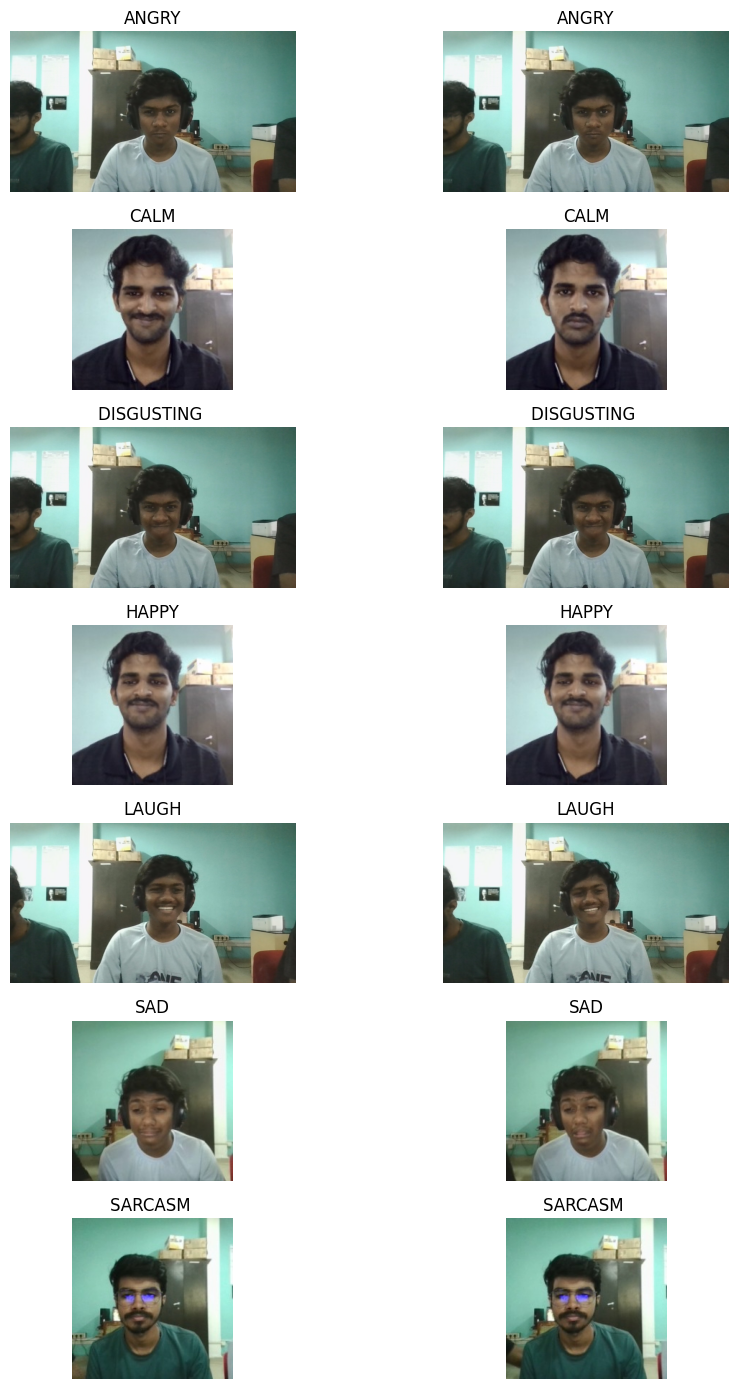

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_samples(directory):
    fig, axes = plt.subplots(len(emotion_labels), 2, figsize=(10, 14))
    for i, emotion in enumerate(emotion_labels):
        files = os.listdir(os.path.join(directory, emotion))[:2]
        for j, img_name in enumerate(files):
            img_path = os.path.join(directory, emotion, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(emotion)
    plt.tight_layout()
    plt.show()

show_samples(train_dir)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 128, 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 571 images belonging to 7 classes.
Found 142 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = len(emotion_labels)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping

start = time.time()
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[EarlyStopping(patience=3)]
)
end = time.time()

print(f"Total Training Time: {end - start:.2f} seconds")


Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4192 - loss: 1.6946 - val_accuracy: 0.8944 - val_loss: 0.6508
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9202 - loss: 0.3184 - val_accuracy: 0.9366 - val_loss: 0.2808
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9729 - loss: 0.0907 - val_accuracy: 0.9366 - val_loss: 0.2213
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9787 - loss: 0.0514 - val_accuracy: 0.9366 - val_loss: 0.1744
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9833 - loss: 0.0397 - val_accuracy: 0.9366 - val_loss: 0.1997
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9881 - loss: 0.0362 - val_accuracy: 0.9648 - val_loss: 0.1554
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9869 - loss: 0.0483 - val_accuracy: 0.9577 - val_loss: 0.1383
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9832 - loss: 0.0670 - val_accuracy: 0.9366 - val_loss:

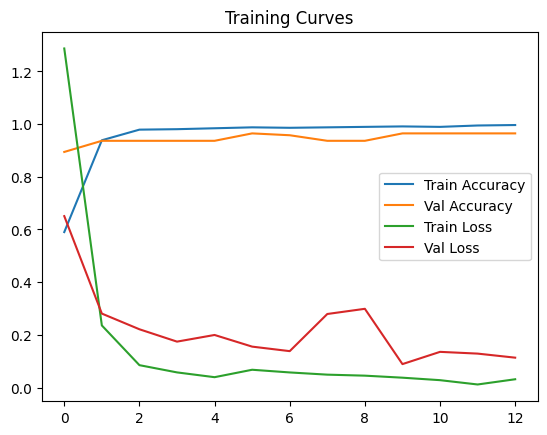

In [ ]:
import numpy as np

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Curves")
plt.show()


Found 140 images belonging to 7 classes.
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Classification Report:
              precision    recall  f1-score   support

       ANGRY       0.95      1.00      0.98        20
        CALM       1.00      0.75      0.86        20
 DISGUSTING        1.00      1.00      1.00        20
       HAPPY       0.80      1.00      0.89        20
       LAUGH       1.00      1.00      1.00        20
         SAD       1.00      0.95      0.97        20
    SARCASM        1.00      1.00      1.00        20

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



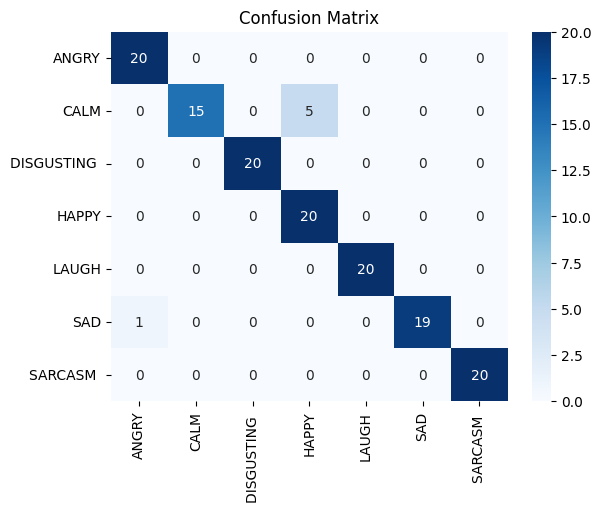

Total Test Time: 2.24 seconds


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

start_test = time.time()
preds = model.predict(test_generator)
end_test = time.time()

y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=emotion_labels, yticklabels=emotion_labels, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(f"Total Test Time: {end_test - start_test:.2f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Dominant Emotion: ANGRY (95.75%)
Emotion Confidence Breakdown:
ANGRY: 95.75%
CALM: 0.21%
DISGUSTING : 0.50%
HAPPY: 0.03%
LAUGH: 0.44%
SAD: 2.66%
SARCASM : 0.41%


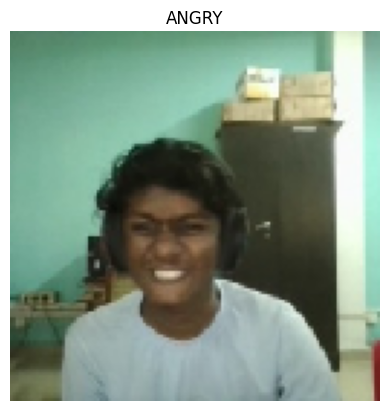

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Dominant Emotion: ANGRY (94.25%)
Emotion Confidence Breakdown:
ANGRY: 94.25%
CALM: 0.33%
DISGUSTING : 0.66%
HAPPY: 0.05%
LAUGH: 0.51%
SAD: 3.53%
SARCASM : 0.67%


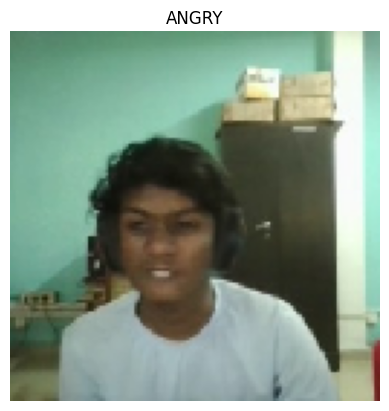

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Dominant Emotion: CALM (76.78%)
Emotion Confidence Breakdown:
ANGRY: 0.01%
CALM: 76.78%
DISGUSTING : 0.05%
HAPPY: 10.47%
LAUGH: 0.37%
SAD: 12.33%
SARCASM : 0.00%


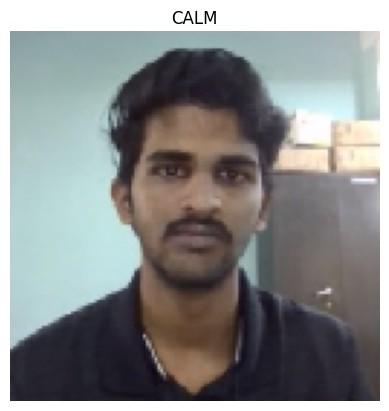

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Dominant Emotion: CALM (76.78%)
Emotion Confidence Breakdown:
ANGRY: 0.01%
CALM: 76.78%
DISGUSTING : 0.05%
HAPPY: 10.47%
LAUGH: 0.37%
SAD: 12.33%
SARCASM : 0.00%


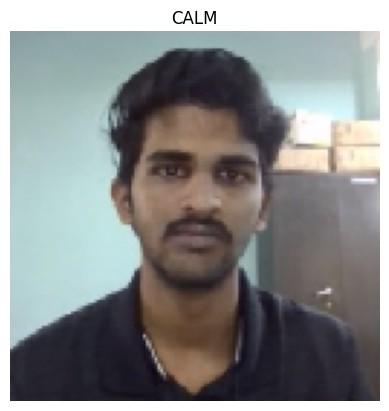

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Dominant Emotion: DISGUSTING  (94.86%)
Emotion Confidence Breakdown:
ANGRY: 0.17%
CALM: 0.21%
DISGUSTING : 94.86%
HAPPY: 2.23%
LAUGH: 0.20%
SAD: 0.19%
SARCASM : 2.14%


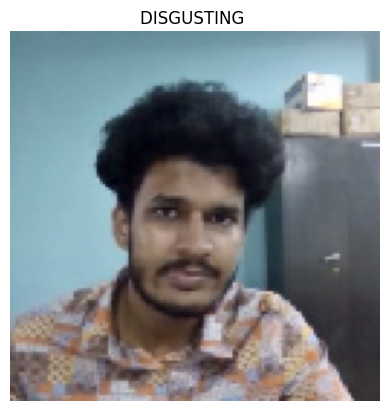

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Dominant Emotion: DISGUSTING  (94.75%)
Emotion Confidence Breakdown:
ANGRY: 0.18%
CALM: 0.21%
DISGUSTING : 94.75%
HAPPY: 2.19%
LAUGH: 0.19%
SAD: 0.19%
SARCASM : 2.29%


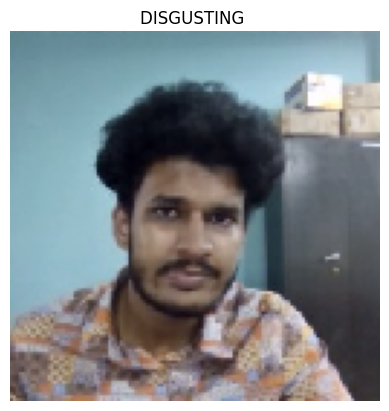

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Dominant Emotion: HAPPY (99.54%)
Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.43%
DISGUSTING : 0.00%
HAPPY: 99.54%
LAUGH: 0.01%
SAD: 0.02%
SARCASM : 0.00%


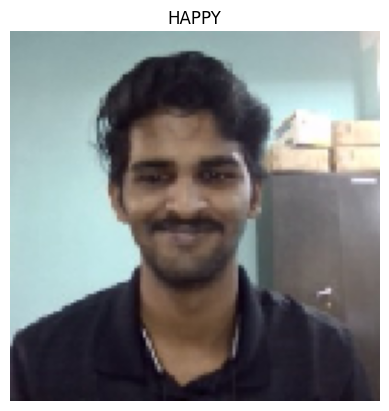

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Dominant Emotion: HAPPY (99.54%)
Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.43%
DISGUSTING : 0.00%
HAPPY: 99.54%
LAUGH: 0.01%
SAD: 0.02%
SARCASM : 0.00%


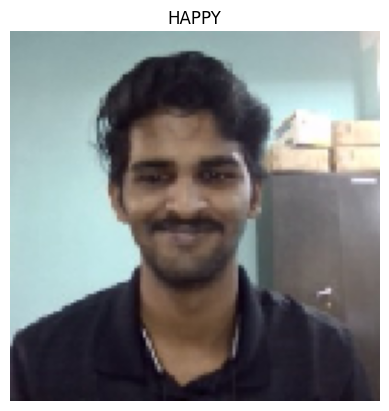

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Dominant Emotion: LAUGH (99.58%)
Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.13%
DISGUSTING : 0.17%
HAPPY: 0.12%
LAUGH: 99.58%
SAD: 0.00%
SARCASM : 0.00%


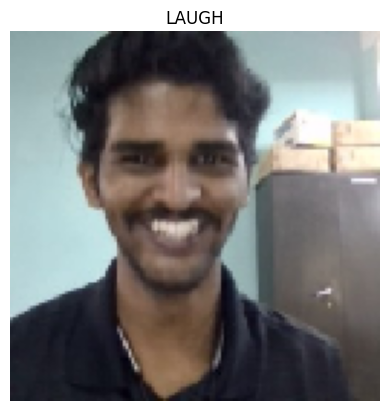

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Dominant Emotion: LAUGH (99.58%)
Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.13%
DISGUSTING : 0.17%
HAPPY: 0.12%
LAUGH: 99.58%
SAD: 0.00%
SARCASM : 0.00%


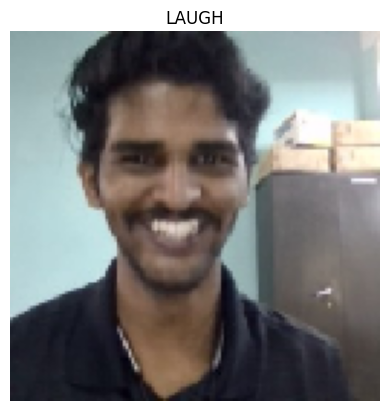

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Dominant Emotion: SAD (99.94%)
Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.04%
DISGUSTING : 0.00%
HAPPY: 0.02%
LAUGH: 0.00%
SAD: 99.94%
SARCASM : 0.00%


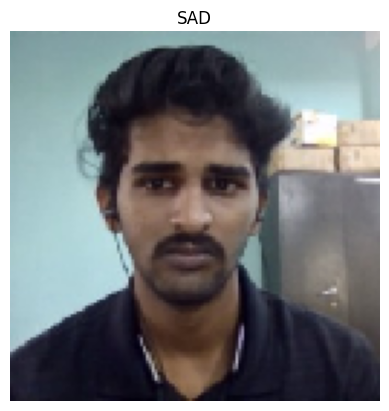

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Dominant Emotion: SAD (99.93%)
Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.05%
DISGUSTING : 0.00%
HAPPY: 0.02%
LAUGH: 0.00%
SAD: 99.93%
SARCASM : 0.00%


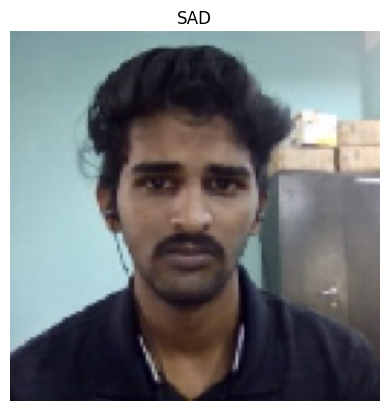

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Dominant Emotion: SARCASM  (99.45%)
Emotion Confidence Breakdown:
ANGRY: 0.06%
CALM: 0.02%
DISGUSTING : 0.29%
HAPPY: 0.04%
LAUGH: 0.06%
SAD: 0.07%
SARCASM : 99.45%


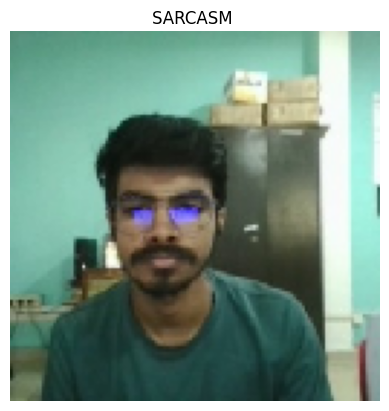

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Dominant Emotion: SARCASM  (99.46%)
Emotion Confidence Breakdown:
ANGRY: 0.06%
CALM: 0.02%
DISGUSTING : 0.29%
HAPPY: 0.04%
LAUGH: 0.06%
SAD: 0.07%
SARCASM : 99.46%


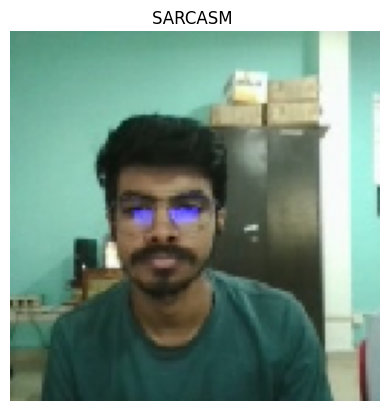

In [ ]:
def predict_and_display(generator, n=2):
    seen = {emotion: 0 for emotion in emotion_labels}
    for i in range(len(generator)):
        img, label = generator[i]
        pred = model.predict(img)[0]
        actual_class = emotion_labels[np.argmax(label)]

        if seen[actual_class] < n:
            seen[actual_class] += 1
            plt.imshow(img[0])
            plt.axis('off')
            predicted_class = emotion_labels[np.argmax(pred)]
            print(f"Dominant Emotion: {predicted_class} ({pred[np.argmax(pred)] * 100:.2f}%)")
            print("Emotion Confidence Breakdown:")
            for idx, emo in enumerate(emotion_labels):
                print(f"{emo}: {pred[idx]*100:.2f}%")
            plt.title(predicted_class)
            plt.show()
        if all(v >= n for v in seen.values()):
            break

predict_and_display(test_generator)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_emotion_from_image(image_path, model, emotion_labels):
    # Load and resize image to match model input (128x128)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # ✅ Match model input shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    img_array = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)

    # Predict
    predictions = model.predict(img_array)[0]
    top_idx = np.argmax(predictions)
    top_emotion = emotion_labels[top_idx]
    top_confidence = predictions[top_idx] * 100

    # Show results
    print(f"\nDominant Emotion: {top_emotion} ({top_confidence:.2f}%)\n")
    print("Emotion Confidence Breakdown:")
    for i, emotion in enumerate(emotion_labels):
        print(f"{emotion}: {predictions[i]*100:.2f}%")

    # Show the image with title
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {top_emotion} ({top_confidence:.2f}%)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Dominant Emotion: LAUGH (99.54%)

Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.12%
DISGUSTING : 0.05%
HAPPY: 0.28%
LAUGH: 99.54%
SAD: 0.01%
SARCASM : 0.00%


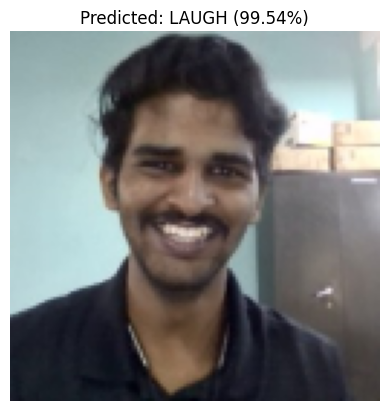

In [ ]:
# Example
predict_emotion_from_image("/content/drive/MyDrive/Copy of 93.jpg", model, emotion_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Dominant Emotion: SAD (99.79%)

Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 0.16%
DISGUSTING : 0.01%
HAPPY: 0.04%
LAUGH: 0.00%
SAD: 99.79%
SARCASM : 0.00%


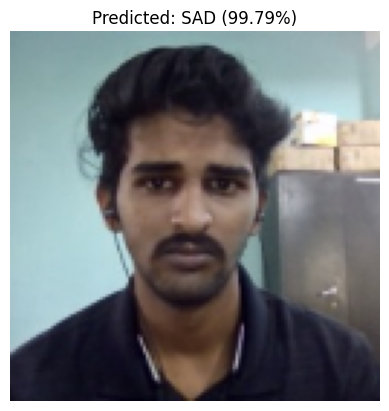

In [ ]:
# Example
predict_emotion_from_image("/content/drive/MyDrive/Copy of 2.jpg", model, emotion_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Dominant Emotion: SARCASM  (99.37%)

Emotion Confidence Breakdown:
ANGRY: 0.08%
CALM: 0.03%
DISGUSTING : 0.30%
HAPPY: 0.05%
LAUGH: 0.07%
SAD: 0.10%
SARCASM : 99.37%


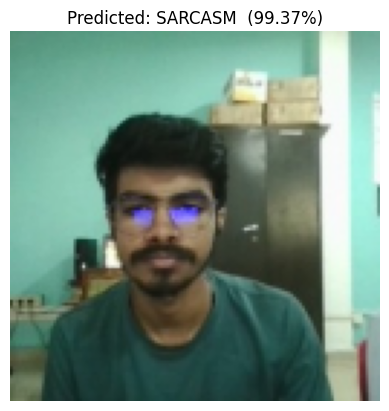

In [ ]:
# Example
predict_emotion_from_image("/content/drive/MyDrive/Copy of 14.jpg", model, emotion_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Dominant Emotion: HAPPY (98.10%)

Emotion Confidence Breakdown:
ANGRY: 0.00%
CALM: 1.81%
DISGUSTING : 0.01%
HAPPY: 98.10%
LAUGH: 0.05%
SAD: 0.04%
SARCASM : 0.00%


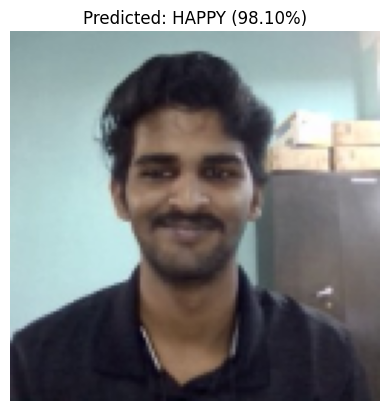

In [ ]:
# Example
predict_emotion_from_image("/content/drive/MyDrive/Copy of 7.jpg", model, emotion_labels)


In [ ]:
import requests
from PIL import Image
import io

def load_image_from_url(url, target_size=(128, 128)):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    img = img.resize(target_size)
    return np.array(img) / 255.0  # Normalize


In [ ]:
def predict_emotion_from_url(url, model, emotion_labels):
    img = load_image_from_url(url, target_size=(128, 128))
    img_array = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)

    predictions = model.predict(img_array)[0]
    top_idx = np.argmax(predictions)
    top_emotion = emotion_labels[top_idx]
    top_confidence = predictions[top_idx] * 100

    # Show results
    print(f"\nDominant Emotion: {top_emotion} ({top_confidence:.2f}%)\n")
    print("Emotion Confidence Breakdown:")
    for i, emotion in enumerate(emotion_labels):
        print(f"{emotion}: {predictions[i]*100:.2f}%")

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {top_emotion} ({top_confidence:.2f}%)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Dominant Emotion: LAUGH (70.83%)

Emotion Confidence Breakdown:
ANGRY: 0.81%
CALM: 3.55%
DISGUSTING : 13.96%
HAPPY: 3.44%
LAUGH: 70.83%
SAD: 0.84%
SARCASM : 6.58%


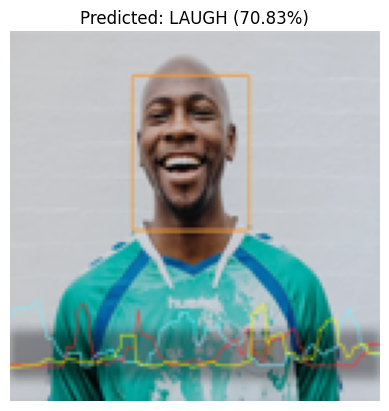

In [ ]:
img_url = "https://www-cdn.morphcast.com/wp-content/uploads/2024/01/Uomo-Riconosciuto-che-ride-1080x920.webp"  # Replace with any face image URL
predict_emotion_from_url(img_url, model, emotion_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

Dominant Emotion: DISGUSTING  (60.36%)

Emotion Confidence Breakdown:
ANGRY: 0.22%
CALM: 20.82%
DISGUSTING : 60.36%
HAPPY: 0.37%
LAUGH: 13.43%
SAD: 1.57%
SARCASM : 3.21%


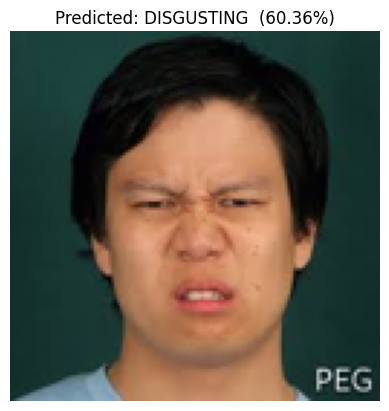

In [ ]:
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBSfeXqfC3eOZYlzPTG1T3sP46fkDFmgT27g&s"  # Replace with any face image URL
predict_emotion_from_url(img_url, model, emotion_labels)
